In [ ]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar

In [ ]:
conn = psycopg2.connect(
    host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='softtouchlenses_4e0b7c925f8444429457581f35678aea',
    password='softtouchlenses_4e0b7c925f8444429457581f35678aea_password',
    database='softtouchlenses_4e0b7c925f8444429457581f35678aea_db'
)

In [ ]:
query1 = """select orders.id as order_id,
created_at::date as order_date,
customer_id as user_id,
order_line_item.product_id as product_id,
order_line_item.name as product_name,
order_line_item.quantity as quantity,
(order_line_item.price - order_line_item.total_discount) as sp
from orders
join order_line_item on orders.id  = order_line_item.order_id
where cancelled_at is NULL;"""

In [ ]:
data = pd.read_sql(query1, conn)

<ipython-input-4-0600e2216395>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query1, conn)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      354 non-null    int64  
 1   order_date    354 non-null    object 
 2   user_id       354 non-null    int64  
 3   product_id    354 non-null    int64  
 4   product_name  354 non-null    object 
 5   quantity      354 non-null    int64  
 6   sp            354 non-null    float64
dtypes: float64(1), int64(4), object(2)
memory usage: 19.5+ KB


In [ ]:
data.order_date

0      2023-11-25
1      2023-11-25
2      2023-11-25
3      2023-11-24
4      2023-11-24
          ...    
349    2023-09-27
350    2023-09-26
351    2023-09-26
352    2023-09-26
353    2023-09-26
Name: order_date, Length: 354, dtype: object

In [ ]:
data

,order_id,order_date,user_id,product_id,product_name,quantity,sp
0,5197599867054,2023-11-25,6729466151086,7282565185710,Red Filter X- Chrome Silver Line Laboratories ...,1,2200.0
1,5197214744750,2023-11-25,6729164030126,7290666942638,Polylite Monthly Color Disposable Contact Lens...,1,650.0
2,5197214744750,2023-11-25,6729164030126,7290666942638,Polylite Monthly Color Disposable Contact Lens...,1,650.0
3,5195141972142,2023-11-24,6727545618606,7249160536238,Power Swimming Goggles FEIKE Rx Prescription O...,1,1399.0
4,5194968072366,2023-11-24,6727402848430,7863970889902,Bausch & Lomb iConnect One Day Daily Contact L...,1,879.0
...,...,...,...,...,...,...,...
349,5110622847150,2023-09-27,6521547718830,7253640577198,Bausch & Lomb BioTrue One Day Disposable Lense...,6,1724.0
350,5110145941678,2023-09-26,5912503648430,7253640577198,Bausch & Lomb BioTrue One Day Disposable Lense...,2,1724.0
351,5110145941678,2023-09-26,5912503648430,7268417863854,Acuvue Vita Monthly Disposable Contact Johnson...,1,1944.0
352,5110107766958,2023-09-26,6227171180718,7270624460974,Aspire Pro Monthly Disposable Contact Lens Coo...,1,1300.0


In [ ]:
#New/Repeat Tag
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel


data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()

In [ ]:
totalcarts=data['order_id'].nunique()
productlevel=data.groupby(['product_id','product_name']).agg(
          Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
     Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
          ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
          NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
          RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
          Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
          AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
    ).reset_index()
productlevel['CartPenetration']=productlevel['Carts']/totalcarts
productlevel['NewUserRatio']=productlevel['NewOrders']/productlevel['Users']
productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']

In [ ]:
productlevel.sort_values('CartPenetration', ascending=False).head(50)

,product_id,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Users,AOVContribution,CartPenetration,NewUserRatio,QpC,ASPXQpC
160,7283065192622,Prosthetic Contact lenses Medium Brown Polylit...,18,18,1000.0,17,1,17,61.224490,0.061224,1.000000,1.000000,1000.000000
156,7280472719534,Aspire Pro Torics Monthly Disposable Contact L...,11,28,1424.0,18,2,10,135.619048,0.037415,1.800000,2.545455,3624.727273
158,7283010306222,Prosthetic Contact lenses Dark Brown Polylite 38,11,14,1000.0,11,0,11,47.619048,0.037415,1.000000,1.272727,1272.727273
159,7283062440110,Prosthetic Contact lenses Light Brown Polylite 38,9,9,1000.0,9,0,9,30.612245,0.030612,1.000000,1.000000,1000.000000
157,7282565185710,Red Filter X- Chrome Silver Line Laboratories ...,6,7,2200.0,6,0,6,52.380952,0.020408,1.000000,1.166667,2566.666667
59,7253640577198,Bausch & Lomb BioTrue One Day Disposable Lense...,5,7,1724.0,4,1,4,41.047619,0.017007,1.000000,1.400000,2413.600000
63,7253640577198,Bausch & Lomb BioTrue One Day Disposable Lense...,5,6,1724.0,5,0,5,35.183673,0.017007,1.000000,1.200000,2068.800000
64,7253640577198,Bausch & Lomb BioTrue One Day Disposable Lense...,4,5,1724.0,3,1,4,29.319728,0.013605,0.750000,1.250000,2155.000000
94,7254315597998,Freshlook ColorBlends Pure Hazel ( 2 pcs in Bo...,4,5,890.0,4,0,4,15.136054,0.013605,1.000000,1.250000,1112.500000
10,7249160536238,Power Swimming Goggles FEIKE Rx Prescription O...,4,4,1399.0,4,0,4,19.034014,0.013605,1.000000,1.000000,1399.000000


In [ ]:
CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)

productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
productlevel['NewRatio_score'] = productlevel['NewUserRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels)).astype('int64')
productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRatio_score'] + productlevel['ASP_score'] + productlevel['QpC_score']


In [ ]:
def ProductCohortLables(df):
    if df['SumScore'] > 15:
        return 'Hero Products'
    elif ((df['CP_score'] >3) and (df['SumScore'] >= 8)and (df['SumScore'] <= 15) and (df['NewRatio_score'] >3)):
        return 'Marquee & New Business Drivers'
    elif ((df['CP_score'] >3) and (df['SumScore'] >= 8)and (df['SumScore'] <= 15)and (df['NewRatio_score'] <=3)):
        return 'Marquee & Repeat Business Drivers'

    elif ((df['ASP_score'] >3) and (df['SumScore'] >= 5)and (df['SumScore'] < 8)and (df['QpC_score'] <=3)):
        return 'High Value & Slow Moving'
    elif ((df['ASP_score'] <=3) and (df['SumScore'] >= 5)and (df['SumScore'] < 8)and (df['QpC_score'] >3)):
        return 'Low Value & Slow Moving'
    else:
        return 'Lagging Products'

In [ ]:
productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables, axis=1)


In [ ]:
productlevel['Product Cohort Lables'].value_counts()

Lagging Products                     171
Marquee & Repeat Business Drivers     33
Marquee & New Business Drivers        14
Hero Products                          6
Name: Product Cohort Lables, dtype: int64

In [ ]:
productlevel

,product_id,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Users,AOVContribution,CartPenetration,NewUserRatio,QpC,ASPXQpC,CP_score,NewRatio_score,ASP_score,QpC_score,SumScore,Product Cohort Lables
0,7246429159598,Affaires Blue Ray Block glasses Frames for Kid...,1,1,845.0,1,0,1,2.874150,0.003401,1.0,1.0,845.0,1,1,2,1,5,Lagging Products
1,7248744317102,Affaires Ultra lightweight Blue Ray glasses Sp...,1,1,599.0,1,0,1,2.037415,0.003401,1.0,1.0,599.0,1,1,1,1,4,Lagging Products
2,7248810541230,Affaires Kids Blue Light Filter Computer Glass...,1,1,845.0,1,0,1,2.874150,0.003401,1.0,1.0,845.0,1,1,2,1,5,Lagging Products
3,7248928243886,Affaires Kids Blue Light Filter Computer Glass...,1,1,845.0,1,0,1,2.874150,0.003401,1.0,1.0,845.0,1,1,2,1,5,Lagging Products
4,7249070686382,Affaires Contact Lens Travel Kit Case Box Cont...,2,2,299.0,1,1,2,2.034014,0.006803,0.5,1.0,299.0,4,1,1,1,7,Lagging Products
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,8091237875886,Freshlook Circle Color Allure Gray - Daily Dis...,2,2,1394.0,2,0,2,9.482993,0.006803,1.0,1.0,1394.0,4,4,3,4,15,Marquee & New Business Drivers
220,8099733176494,Air Optix plus HydraGlyde Monthly Disposable A...,1,1,1154.0,1,0,1,3.925170,0.003401,1.0,1.0,1154.0,4,4,3,4,15,Marquee & New Business Drivers
221,8099733176494,Air Optix plus HydraGlyde Monthly Disposable A...,1,2,1154.0,1,0,1,7.850340,0.003401,1.0,2.0,2308.0,4,4,3,4,15,Marquee & New Business Drivers
222,8099733176494,Air Optix plus HydraGlyde Monthly Disposable A...,1,1,1154.0,1,0,1,3.925170,0.003401,1.0,1.0,1154.0,4,4,3,4,15,Marquee & New Business Drivers


In [ ]:
segstats=productlevel.groupby(
   'Product Cohort Lables'
).agg(
       ProductCount=pd.NamedAgg(column='product_id', aggfunc='nunique'),
       Orders=pd.NamedAgg(column='Carts', aggfunc='sum'),
       Users=pd.NamedAgg(column='Users', aggfunc='sum'),
       AverageSellingPrice=pd.NamedAgg(column='ASP', aggfunc='mean'),
       QuantityperCart=pd.NamedAgg(column='QpC', aggfunc='mean'),
       CartPenetration  =pd.NamedAgg(column='CartPenetration', aggfunc='mean'),
       NewUserRatio=pd.NamedAgg(column='NewUserRatio', aggfunc='mean'),
      NewOrders=pd.NamedAgg(column='NewOrders', aggfunc='sum'),
       ASPXQpC=pd.NamedAgg(column='ASPXQpC', aggfunc='sum'),
       AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
       Top10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[:10]),
      Bottom10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[-10:-1])

 ).reset_index()
segstats=segstats.sort_values('CartPenetration', ascending =False)
segstats
segstats['ProductCountMix']=segstats['ProductCount']/segstats['ProductCount'].sum()
segstats['OrdersMix']=segstats['Orders']/segstats['Orders'].sum()
segstats['UsersMix']=segstats['Users']/segstats['Users'].sum()
segstats['AOVContribution(%)']=segstats['AOVContribution']/segstats['AOVContribution'].sum()
segstats['OrderPerSKU']=segstats['Orders']/segstats['ProductCount']

In [ ]:
segstats.columns

Index(['Product Cohort Lables', 'ProductCount', 'Orders', 'Users',
       'AverageSellingPrice', 'QuantityperCart', 'CartPenetration',
       'NewUserRatio', 'NewOrders', 'ASPXQpC', 'AOVContribution', 'Top10SKUs',
       'Bottom10SKUs', 'ProductCountMix', 'OrdersMix', 'UsersMix',
       'AOVContribution(%)', 'OrderPerSKU'],
      dtype='object')

In [ ]:
SummaryTable=segstats[['Product Cohort Lables', 'ProductCount','OrdersMix',
       'UsersMix','AverageSellingPrice',
       'CartPenetration',"QuantityperCart",'NewUserRatio','AOVContribution',
       'Top10SKUs', 'Bottom10SKUs','OrderPerSKU', ]]


In [ ]:
SummaryTable.to_csv('st.csv')
#productlevel.to_csv('pl.csv')

In [ ]:
SummaryTable


,Product Cohort Lables,ProductCount,OrdersMix,UsersMix,AverageSellingPrice,CartPenetration,QuantityperCart,NewUserRatio,AOVContribution,Top10SKUs,Bottom10SKUs,OrderPerSKU
3,Marquee & Repeat Business Drivers,14,0.351032,0.344411,1480.848485,0.012266,1.203214,0.962121,662.142857,[Power Swimming Goggles FEIKE Rx Prescription ...,[Bausch & Lomb BioTrue One Day Disposable Lens...,8.500000
2,Marquee & New Business Drivers,11,0.100295,0.096677,1075.000000,0.008260,1.181818,1.057143,216.744898,[Aspire Pro Torics Monthly Disposable Contact ...,[Affaires Ultra Thiner Portable Mobile Stickin...,3.090909
0,Hero Products,4,0.035398,0.036254,2718.166667,0.006803,1.250000,1.194444,151.738095,[Bausch & Lomb PureVision 2 Lens For Presbyopi...,[Bausch & Lomb PureVision 2 Lens For Presbyopi...,3.000000
1,Lagging Products,84,0.513274,0.522659,1162.912281,0.003461,1.280702,0.964912,948.758503,[Affaires Blue Ray Block glasses Frames for Ki...,[Bausch & Lomb BioTrue One Day Disposable Lens...,2.071429


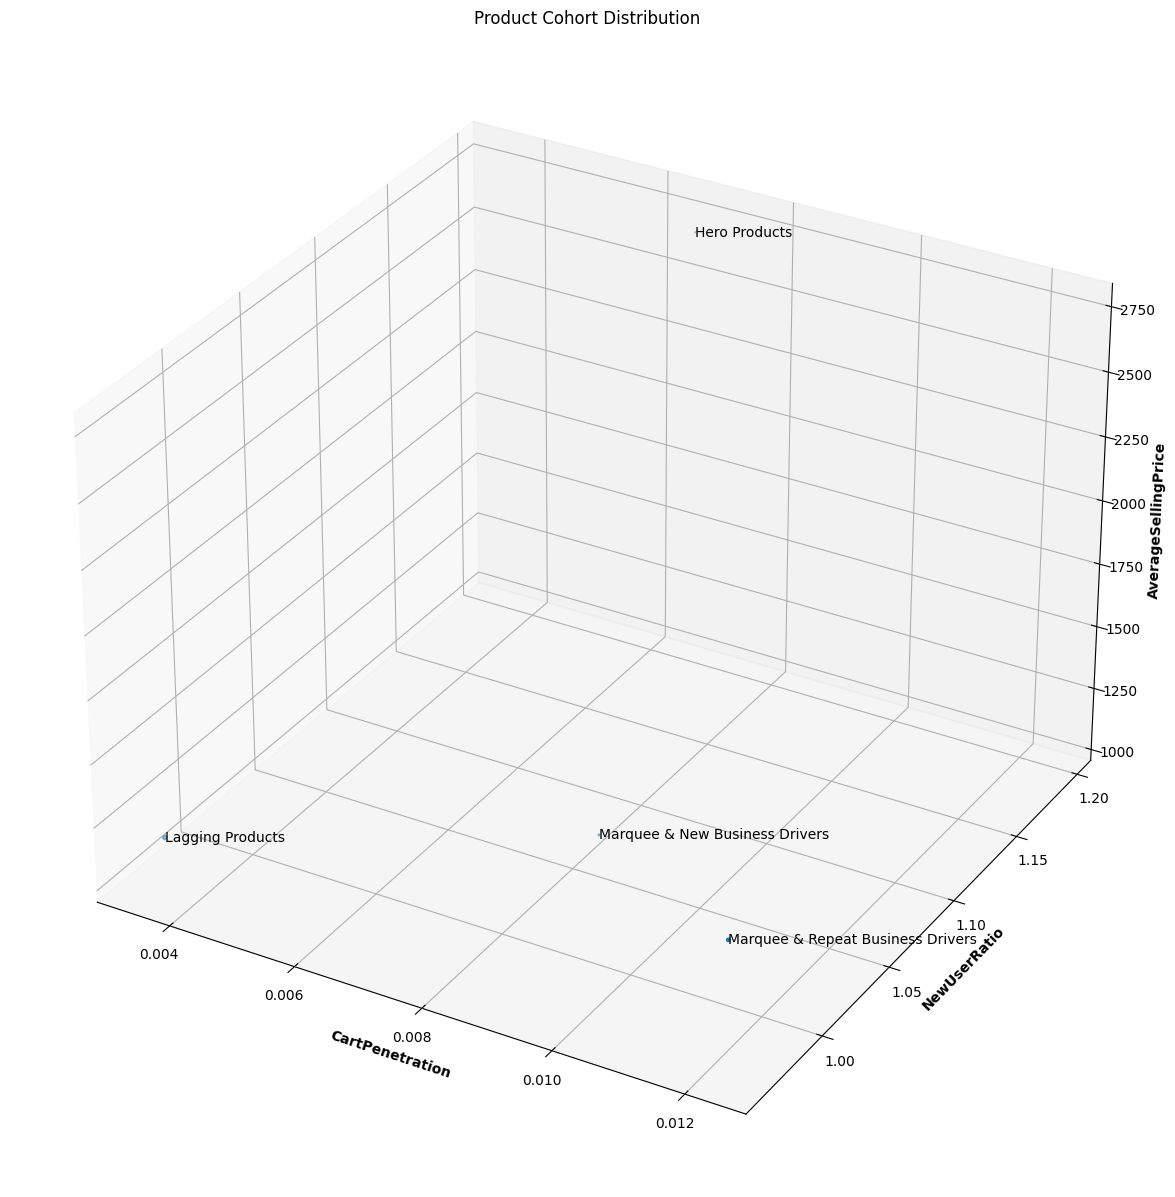

In [ ]:
#Visualization of cohorts with key parameters as axises
fig = plt.figure(figsize = (15, 15))
ax = plt.axes(projection ="3d")
size=segstats['Users']*.05
# Creating plot
ax.scatter3D(segstats['CartPenetration'], segstats['NewUserRatio'],segstats['AverageSellingPrice'], s=size)
plt.title("Product Cohort Distribution")
ax.set_xlabel('CartPenetration', fontweight ='bold')
ax.set_ylabel('NewUserRatio', fontweight ='bold')
ax.set_zlabel('AverageSellingPrice', fontweight ='bold')
for i in range(len(segstats)):
     ax.text(segstats['CartPenetration'][i],
               segstats['NewUserRatio'][i],
             segstats['AverageSellingPrice'][i],
               segstats['Product Cohort Lables'][i],
               horizontalalignment='left',
               rotation=25, wrap=True,
               verticalalignment='center',
               size='medium', color='black')
